<a href="https://colab.research.google.com/github/handielg/Python/blob/main/Reinforcement_Learning_based_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Reinforcement Learning based Trading Strategy

En este caso de estudio, crearemos una estrategia comercial de principio a fin basada en el aprendizaje reforzado.

##1. Definición del problema¶
En este marco de aprendizaje reforzado para la estrategia comercial, el algoritmo realiza una acción (comprar, vender o mantener) según el estado actual del precio de las acciones. El algoritmo se entrena utilizando el marco de Deep Q-Learning, para ayudarnos a predecir la mejor acción, en función de los precios de las acciones actuales.

Los componentes clave del marco basado en RL son:

- Agente: Agente comercial.
- Acción: comprar, vender o mantener.
- Función de recompensa: las ganancias y pérdidas realizadas (PnL) se utilizan como función de recompensa para este estudio de caso. La recompensa depende de la acción:

- Venta: ganancias y pérdidas realizadas (precio de venta - precio de compra)
- Compra: Sin recompensa
- Sostener: Sin recompensa
- Estado: las diferencias de los precios de las acciones anteriores para una ventana de tiempo determinada se utiliza como estado.

Los datos utilizados para este estudio de caso serán de AAPL.

##2. Introducción: carga de los paquetes de datos y python

###2.1. Cargando los paquetes de Python

In [ ]:
!pip install tensorflow
!pip install yfinance

In [7]:

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#para los datos financieros
import yfinance as yf

#Import Model Packages for reinforcement learning
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque

In [8]:
#importamos los datos de yahoo.
dataset = yf.download("AAPL", start="2010-01-01", end="2020-11-27", group_by='column')

[*********************100%***********************]  1 of 1 completed


In [9]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
type(dataset)

pandas.core.frame.DataFrame

##3. Exploramos los datos

In [11]:
# shape
dataset.shape

(2745, 6)

In [12]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.539882,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656428,6.551187,601904800
2010-01-06,7.656428,7.686786,7.526786,7.534643,6.446983,552160000
2010-01-07,7.562500,7.571429,7.466072,7.520714,6.435065,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.477847,447610800


Los datos tienen un total de 2745 filas y seis columnas que contienen el precio de apertura, máximo, mínimo, cierre y cierre ajustado junto con el volumen total. El cierre ajustado es el precio de cierre ajustado por la división y los dividendos. A los efectos de este estudio de caso, nos centraremos en el precio de cierre.

In [13]:
# describe data
set_option('precision', 3)
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2745.000,2745.000,2745.000,2745.000,2745.000,2.745e+03
mean,32.955,33.295,32.613,32.967,31.084,2.875e+08
std,23.081,23.397,22.751,23.087,23.488,2.299e+08
min,6.870,7.000,6.795,6.859,5.869,2.045e+07
25%,17.357,17.584,17.194,17.401,15.208,1.211e+08
50%,26.847,27.075,26.573,26.833,24.653,2.043e+08
75%,42.650,43.035,42.373,42.722,40.972,3.906e+08
max,137.590,137.980,130.530,134.180,133.949,1.881e+09


Vemos como lucen los datos

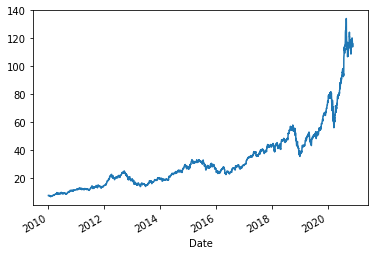

In [14]:
dataset['Close'].plot()

##4. Preparación de datos¶

###4.1. Limpieza de datos
Comprobemos los NA en las filas, elimínelos o rellénelos con la media de la columna.

In [15]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


En caso de que haya valores nulos, complete los valores faltantes con el último valor disponible en el conjunto de datos.

In [16]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622,7.661,7.585,7.643,6.540,493729600
2010-01-05,7.664,7.700,7.616,7.656,6.551,601904800


Los parámetros de los conglomerados son los índices y las variables utilizadas en el conglomerado son las columnas. Por lo tanto, los datos están en el formato correcto para ser enviados a los algoritmos de agrupamiento.


##5. Evaluar algoritmos y modelos

###5.1. Dividimos en entrenamiento y prueba.
Usaremos el 80% del conjunto de datos para modelar y usaremos el 20% para pruebas.

In [17]:
X=list(dataset["Close"])
X=[float(x) for x in X]

In [18]:
validation_size = 0.2
# En caso de que los datos no dependan de la serie de tiempo, entonces el entrenamiento y la división de prueba deben realizarse en función de una muestra secuencial
# Esto se puede hacer seleccionando un punto de división arbitrario en la lista ordenada de observaciones y creando dos nuevos conjuntos de datos.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

###5.2. Pasos y módulos de implementación
El algoritmo, en términos simples, decide si comprar, vender o retener, cuando se le proporciona el precio de mercado actual. El algoritmo se basa en un enfoque "basado en Q-learning" y utilizó Deep-Q-Network (DQN) para elaborar una política. Como se discutió anteriormente, el nombre “Q-learning” proviene de la función Q (s, a), que basada en el estado s y la acción proporcionada a devuelve la recompensa esperada.

Para implementar este algoritmo DQN se implementan varias funciones y módulos que interactúan entre sí durante el entrenamiento del modelo. A continuación se describe un resumen de los módulos y funciones.

1- Clase Agent: El agente se define como la clase "Agent", que contiene las variables y funciones miembro que realizan el Q-Learning que discutimos antes. Un objeto de la clase "Agente" se crea usando la fase de entrenamiento y se usa para entrenar el modelo.
2- Funciones de ayuda: en este módulo, creamos funciones adicionales que son útiles para el entrenamiento. Hay dos funciones auxiliares que tenemos que son las siguientes.
3- Módulo de entrenamiento: En este paso, realizamos el entrenamiento de los datos usando las variables y los métodos de agente y ayudante de funciones. Esto nos proporcionará una de las tres acciones (es decir, comprar, vender o retener) según los estados de los precios de las acciones al final del día. Durante el entrenamiento, se predice la acción prescrita para cada día, se calculan las recompensas y las ponderaciones del modelo de Q-learning basado en el aprendizaje profundo se actualizan de forma iterativa a lo largo de varios episodios. Además, las ganancias y pérdidas de cada acción se resumen para ver si se ha producido una ganancia general. El objetivo es maximizar el beneficio total. Proporcionamos una inmersión profunda en la interacción entre diferentes módulos y funciones en la sección "Entrenamiento del modelo" a continuación. Veamos en detalle cada uno de los módulos

### 5.3. Script de agente
La definición del script del Agente es el paso clave, ya que consta de En esta sección, formaremos un agente que realizará el aprendizaje por refuerzo basado en el Q-Learning. 
Realizaremos los siguientes pasos para conseguirlo:

1. Cree una clase de agente cuya función inicial tenga en cuenta el tamaño del lote, el tamaño del estado y una función booleana de evaluación para verificar si la capacitación está en curso.
2. En la clase de agente, cree los siguientes métodos:
- Constructor: El constructor inicia todos los parámetros.
- Modelo: esta función tiene un modelo de aprendizaje profundo para asignar el estado a la acción.
- Función Act: Devuelve una acción, dado un estado, utilizando la salida de la función modelo. El número de acciones se define como 3: sentarse, comprar, vender
- expReplay: crea una función de reproducción que agrega, muestrea y evalúa un búfer. Agregue una nueva experiencia a la memoria intermedia de reproducción. Muestra aleatoriamente un lote de tuplas experimentadas de la memoria. En la siguiente función, muestreamos estados aleatoriamente de un búfer de memoria. La reproducción de experiencias almacena un historial de transiciones de estado, acción, recompensa y siguiente estado que experimenta el agente. Muestra aleatoriamente mini lotes de esta experiencia para actualizar los pesos de la red en cada paso de tiempo antes de que el agente seleccione una acción ε-codiciosa.
La reproducción de la experiencia aumenta la eficiencia de la muestra, reduce la autocorrelación de las muestras que se recopilan durante el aprendizaje en línea y limita la retroalimentación debido a los pesos actuales que producen muestras de entrenamiento que pueden conducir a mínimos locales o divergencias.

In [19]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from IPython.core.debugger import set_trace

import numpy as np
import random
from collections import deque

class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        #State size depends and is equal to the the window size, n previous days
        self.state_size = state_size # normalized previous days, 
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        #self.epsilon_decay = 0.9
        
        #self.model = self._model()

        self.model = load_model(model_name) if is_eval else self._model()

    #Deep Q Learning model- returns the q-value when given state as input 
    def _model(self):
        model = Sequential()
        #Input Layer
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        #Hidden Layers
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        #Output Layer 
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
    
    #Return the action on the value function
    #With probability (1-$\epsilon$) choose the action which has the highest Q-value.
    #With probability ($\epsilon$) choose any action at random.
    #Intitially high epsilon-more random, later less
    #The trained agents were evaluated by different initial random condition
    #and an e-greedy policy with epsilon 0.05. This procedure is adopted to minimize the possibility of overfitting during evaluation.
 
    def act(self, state): 
        #If it is test and self.epsilon is still very high, once the epsilon become low, there are no random
        #actions suggested.
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)        
        options = self.model.predict(state)
        #set_trace()
        #action is based on the action that has the highest value from the q-value function.
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        
        # the memory during the training phase. 
        for state, action, reward, next_state, done in mini_batch:
            target = reward # reward or Q at time t    
            #update the Q table based on Q table equation
            #set_trace()
            if not done:
                #set_trace()
                #max of the array of the predicted. 
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])     
                
            # Q-value of the state currently from the table    
            target_f = self.model.predict(state)
            # Update the output Q table for the given action in the table     
            target_f[0][action] = target
            #train and fit the model where state is X and target_f is Y, where the target is updated. 
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

###5.4. Funciones auxiliares
En este script, crearemos funciones que serán útiles para el entrenamiento. Creamos las siguientes funciones:

1) formatPrice: formatee el precio con dos decimales, para reducir la ambigüedad de los datos:

2) getStockData: Devuelve un vector de datos de stock del archivo CSV. Convierta los precios de cierre de las acciones de los datos en vectores y devuelva un vector de todos los precios de las acciones.

3) getState: Defina una función para generar estados a partir del vector de entrada. Cree la serie de tiempo generando los estados a partir de los vectores creados en el paso anterior. La función para esto toma tres parámetros: los datos; una hora, t (el día que desea predecir); y una ventana (cuántos días para retroceder en el tiempo). Entonces se medirá la tasa de cambio entre estos vectores y se basará en la función sigmoidea.

In [20]:
import numpy as np
import math

# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# # returns the vector containing stock data from a fixed file 
# def getStockData(key):
#     vec = []
#     lines = open("data/" + key + ".csv", "r").read().splitlines()

#     for line in lines[1:]:
#         vec.append(float(line.split(",")[4])) #Only Close column

#     return vec

# returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t

def getState(data, t, n):    
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

###5.5. Entrenando los datos
Procederemos a entrenar los datos, en base a nuestros métodos de agente y ayudante. Esto nos proporcionará una de las tres acciones, basadas en los estados de los precios de las acciones al final del día. Estos estados pueden ser comprar, vender o mantener. Durante el entrenamiento, se predice la acción prescrita para cada día y se calcula el precio (ganancia, pérdida o sin cambios) de la acción. La suma acumulada se calculará al final del período de formación y veremos si ha habido una ganancia o una pérdida. El objetivo es maximizar el beneficio total.

Pasos:

- Defina el número de días de mercado a considerar como tamaño de ventana y defina el tamaño de lote con el que se entrenará la red neuronal.
- Cree una instancia del agente de stock con el tamaño de la ventana y el tamaño del lote.
Lea los datos de entrenamiento del archivo CSV, usando la función auxiliar.
- El recuento de episodios está definido. El agente examinará los datos tantas veces. Un episodio representa un paso completo sobre los datos.
- Podemos empezar a recorrer los episodios.
- Cada episodio debe iniciarse con un estado basado en los datos y el tamaño de la ventana. El inventario de existencias se inicializa antes de pasar por los datos.
- Comience a iterar todos los días de los datos de existencias. La probabilidad de acción la predice el agente.
- A continuación, se repiten todos los días de negociación y el agente puede actuar sobre los datos. Todos los días, el agente decide una acción. Según la acción, las acciones se mantienen, venden o compran.
- Si la acción es 1, el agente compra las acciones.
- Si la acción es 2, el agente vende las existencias y las elimina del inventario. Sobre la base de la venta, se calcula la ganancia (o pérdida).
- Si la acción es 0, entonces no hay intercambio. El estado se puede llamar tenencia durante ese período.
- Los detalles del estado, el siguiente estado, la acción, etc. se guardan en la memoria del objeto del agente, que la función exeReply utiliza más adelante.

###Habilitar y probar la GPU
Primero, deberá habilitar las GPU para el portátil:

- Vaya a Editar → Configuración del cuaderno
- Seleccione GPU en el menú desplegable Acelerador de hardware
- A continuación, confirmaremos que podemos conectarnos a la GPU con tensorflow:

In [22]:
#Solicitamos GPU
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


###Habilitar y probar la TPU

De esta forma podemos solicitar TPU, DA ERROR.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [28]:
from IPython.core.debugger import set_trace
window_size = 1
agent = Agent(window_size)
#In this step we feed the closing value of the stock price 
data = X_train
l = len(data) - 1
#
batch_size = 32
#An episode represents a complete pass over the data.
episode_count = 10

for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)
    #set_trace()
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in range(l):
        action = agent.act(state)    
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            #print("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)      
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            #print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
        done = True if t == l - 1 else False
        #appends the details of the state action etc in the memory, which is used further by the exeReply function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            #set_trace()
            #pd.DataFrame(np.array(agent.memory)).to_csv("Agent"+str(e)+".csv")
            #Chart to show how the model performs with the stock goin up and down for each 
            plot_behavior(data,states_buy, states_sell, total_profit)
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)    
            

    if e % 2 == 0:
        agent.model.save("model_ep" + str(e))

Running episode 0/10


KeyboardInterrupt: ignored

In [25]:
#Deep Q-Learning Model
print(agent.model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 27        
Total params: 2,499
Trainable params: 2,499
Non-trainable params: 0
_________________________________________________________________
None


##6. Prueba de los datos
Después de entrenar los datos, se prueban con el conjunto de datos de prueba. Nuestro modelo resultó en una ganancia general. Lo mejor del modelo fue que las ganancias siguieron mejorando con el tiempo, lo que indica que estaba aprendiendo bien y tomando mejores acciones.

In [26]:
#agent ya está definido en el conjunto de entrenamiento anterior.
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
#Get the trained model
model_name = "model_ep"+str(episode_count)
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []

------------------------------------------
Total Profit: $0.00
------------------------------------------


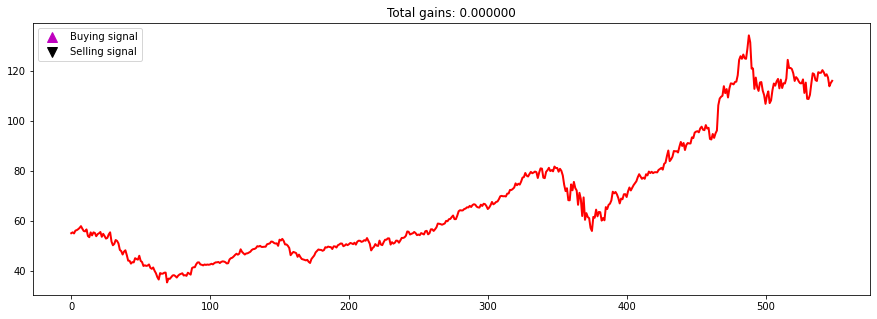

In [27]:
for t in range(l_test):
    action = agent.act(state)
    #print(action)
    #set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(test_data[t])
        states_buy_test.append(t)
        print("Buy: " + formatPrice(test_data[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        #reward = test_data[t] - bought_price
        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
        print("Sell: " + formatPrice(test_data[t]) + " | profit: " + formatPrice(test_data[t] - bought_price))

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")
        
plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)

Al observar los resultados anteriores, nuestro modelo arrojó una ganancia general y podemos decir que nuestro agente DQN se desempeña bastante bien en el conjunto de pruebas. Sin embargo, el rendimiento del modelo se puede mejorar aún más optimizando los hiperparámetros como se discutió en la sección de ajuste del modelo anterior. Además, dada la alta complejidad y la baja interpretabilidad del modelo, lo ideal sería que se realicen más pruebas en diferentes períodos de tiempo antes de implementar el modelo para el comercio en vivo.

##Conclusiones

- Observamos que no tenemos que decidir la estrategia o política para operar. El algoritmo decide la política por sí mismo, y el enfoque general es mucho más simple y tiene más principios que el enfoque basado en el aprendizaje supervisado.

- La política se puede parametrizar mediante un modelo complejo, como una red neuronal profunda, y podemos aprender políticas que son más complejas y poderosas que cualquier regla de un comerciante humano.
